# Selecting C-type asteroids from the Gaia DR3 reflectance spectra with machine learning

Reproduce the initial classification by Joost Barendse of C-type vs non-C-type asteroid using ML algorithms.

The Gaia DR3 data was simply downloaded in full with the query:
```sql
select * from gaiadr3.sso_reflectance_spectrum
```
The reflectance spectra are corrected according to the prescriptions by [Tinaut-Ruano et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023A%26A...669L..14T/abstract). The factors by which to multiply the `reflectance_spectrum` column are listed in their table 1.

| Wavelength (nm) | Correction Factor |
| -- | -- |
| 374.0 | 1.07 |
| 418.0 | 1.05 |
| 462.0 | 1.02 |
| 506.0 | 1.01 |

Additional data on the asteroids, their proper orbital elements, inverse diameters and magnitudes $H$, were downloaded from the [MP3C](https://mp3c.oca.eu/) database (on November 18 2023). An unconstrained "best values" search was done to get all data. These data are added to the table created with `create_sso_objects_file.py`. This was done by merging the tables in [topcat](https://www.star.bris.ac.uk/~mbt/topcat/) using the exact match on MPC numbers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.visualization import HistEqStretch, ImageNormalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn.neural_network import MLPClassifier

from astropy.table import Table

from tqdm import tqdm

from agabpylib.plotting.plotstyles import useagab, apply_tufte
from agabpylib.stats.robuststats import rse
from reflspectratools import (
    plot_spectra_collection,
    load_dr3_data,
    create_ml_training_classes,
    extract_spectra,
    prep_classifier_inputs,
)

useagab(fontsize=22, linewidths=3, axislinewidths=2)

## Read in the data
Read the Gaia DR3 data and the classified asteroid MPC numbers for use in ML classification training and application.

__NOTE__ that for the initial seperation of C-types from the rest of the asteroids the full range of wavelengths should be used for the spectra. That this is the case can be checked by re-running with `ssodata = load_dr3_data(clipspectra=True)`.

In [2]:
ssospectra = load_dr3_data(clipspectra=False)
n_asteroids = ssospectra.number_mp.unique().size
wavelengths = ssospectra["wavelength"].unique()
wavelengths.sort()
ssotypes = create_ml_training_classes(ssospectra, filter=True)

ssoparams = Table.read("./data/DR3ReflectanceSpectraMP3C.fits").to_pandas()
ssoparams["denomination"] = ssoparams.denomination.str.decode("utf-8")
ssoparams["parent_name"] = ssoparams.parent_name.str.decode("utf-8")

## Classification of C-type vs other
Train an ML algorithm to classify C-Type vs other types of asteroids. Use the type labels from the asteroids classified by Joost and Marco.

### Prepare the training data

In [3]:
training_spectra, training_labels, data_to_be_classified = prep_classifier_inputs(
    ssospectra, ssotypes
)

### Train an MLP neural network classifier and apply to the DR3 data

The code below carries out the following steps:
* Run the training and classification $m=100$ times with different random states for `sklearn.neural_network.MLPClassifier`
    * The MLPClassifier is instantiated with `early_stopping=True` which means that automatically 10 per cent of the training data is set aside for validation
* After each training step, apply the classifier to all asteroid by predicting their class probabilities.
    * The probablity of being C-type is stored in a $m\times n_\mathrm{asteroids}$ matrix
* In the subsequent code blocks the median class probablity $\theta$ (over the $m$ runs) and the RSE of the class probabilities $\zeta$ are used to decide on the classification of asteroids
    * An asteroid with a combination of high $\theta$ and small $\zeta$ is considered to be of C-type
    * An asteroid with a combination of low $\theta$ and small $\zeta$ is considered to be of other type
    * Other asteroids have uncertain classifications

100%|██████████| 100/100 [02:03<00:00,  1.23s/it]


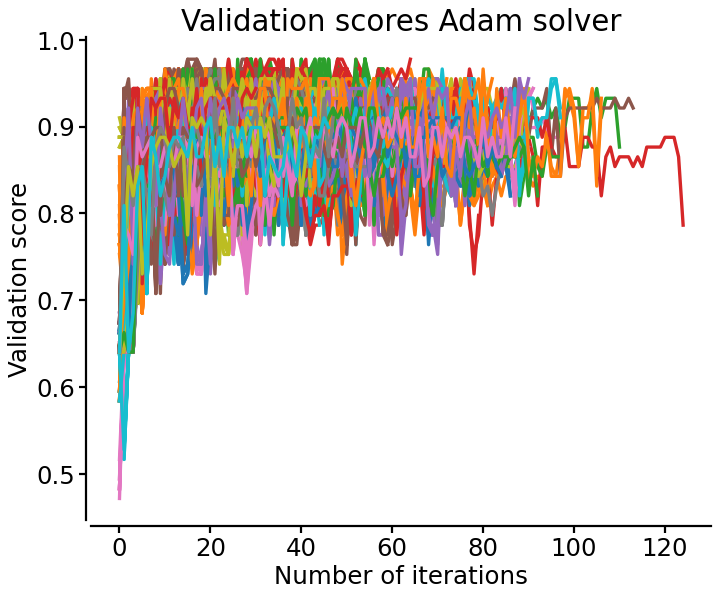

In [4]:
# Run the algorithm m times, each time with a different random state.
mnoise = 10
mclf = 100
probability_matrix = np.zeros((mclf * mnoise, n_asteroids))

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
apply_tufte(ax)
ax.set_xlabel("Number of iterations")
ax.set_ylabel("Validation score")
ax.set_title("Validation scores Adam solver")

# train and classify with an ensemble of neural networks

for j in range(mnoise):
    if j == 0:
        rrng = None
    else:
        rrng = np.random.default_rng(j)
    training_spectra, training_labels, data_to_be_classified = prep_classifier_inputs(
        ssospectra, ssotypes, rng=rrng
    )
    for jj in tqdm(range(mclf)):
        clf = MLPClassifier(
            solver="adam",
            alpha=1e-05,
            batch_size=100,
            activation="tanh",
            hidden_layer_sizes=(200, 200, 200, 200),
            max_iter=200,
            random_state=jj,
            early_stopping=True,
            n_iter_no_change=25,
        )
        clf.fit(training_spectra, training_labels)
        ax.plot(clf.validation_scores_)

        ctype_index = np.argwhere(clf.classes_ == 1).ravel()[0]
        probability_matrix[j * mclf + jj, :] = clf.predict_proba(data_to_be_classified)[
            :, ctype_index
        ]

plt.show()

### Examine the results
First the median probabilities and their RSEs are stored in the `ssoclasses` DataFrame. This table is then used to plot various aspects of the results.

In [17]:
ssoparams["ctype_median_prob"] = np.median(probability_matrix, axis=0)
ssoparams["ctype_rse_prob"] = rse(probability_matrix, ax=0)
ssoparams["ctype_mean_prob"] = np.mean(probability_matrix, axis=0)
ssoparams["ctype_std_prob"] = np.std(probability_matrix, axis=0)
Table.from_pandas(ssoparams).write(
    "./outputs/DR3ReflSpecCvsOtherType.fits", format="fits", overwrite=True
)

### Histogram of class probabilities
Histograms of $\theta$ are shown below for different thresholds on $s$. A clear seperation between $\theta\sim0$ and $\theta\sim1$ starts to appear for $\zeta\lesssim0.1$.

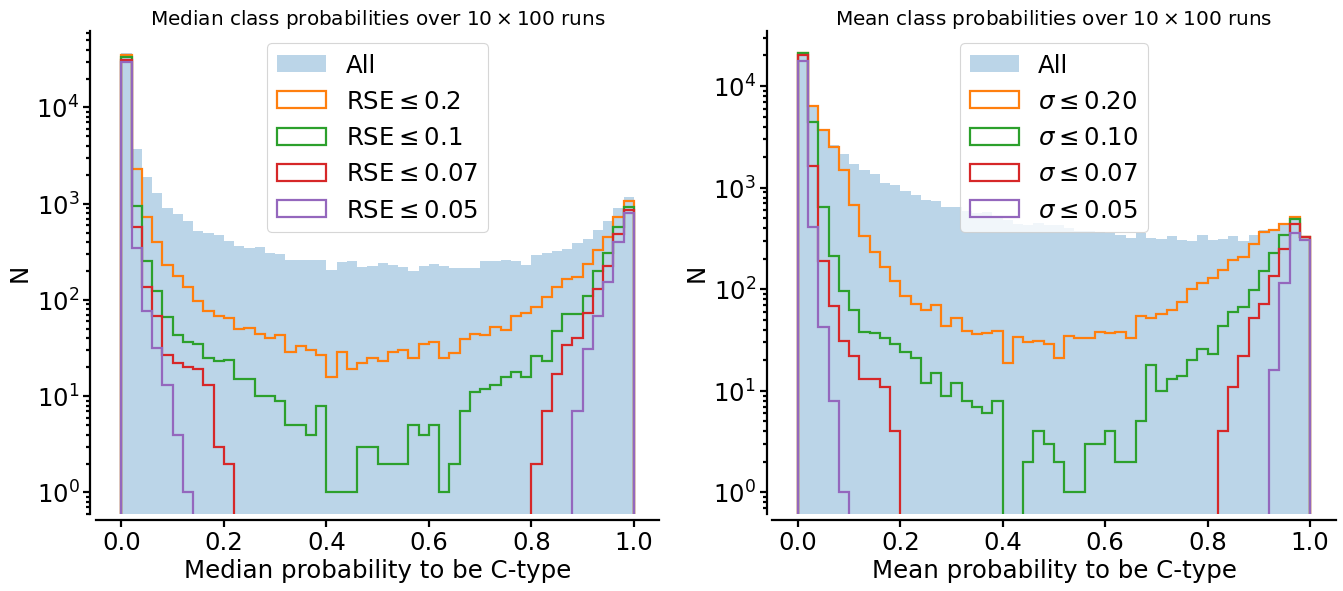

In [27]:
fig, (axA, axB) = plt.subplots(1, 2, figsize=(20, 8))
apply_tufte(axA)
apply_tufte(axB)

nbins = 50
rselims = [0.2, 0.1, 0.07, 0.05]
stdlims = [0.2, 0.1, 0.07, 0.05]

axA.hist(
    ssoparams.ctype_median_prob,
    bins=nbins,
    log=True,
    range=(0, 1),
    alpha=0.3,
    label="All",
)
for rselim in rselims:
    axA.hist(
        ssoparams.ctype_median_prob[ssoparams.ctype_rse_prob <= rselim],
        bins=nbins,
        log=True,
        range=(0, 1),
        histtype="step",
        lw=2,
        label=rf"$\mathrm{{RSE}}\leq{rselim}$",
    )
axA.set_xlabel("Median probability to be C-type")
axA.set_ylabel("N")
axA.set_title(
    rf"Median class probabilities over ${mnoise}\times{mclf}$ runs", fontsize=18
)
axA.legend()

axB.hist(
    ssoparams.ctype_mean_prob,
    bins=nbins,
    log=True,
    range=(0, 1),
    alpha=0.3,
    label="All",
)
for stdlim in stdlims:
    axB.hist(
        ssoparams.ctype_mean_prob[ssoparams.ctype_std_prob <= stdlim],
        bins=nbins,
        log=True,
        range=(0, 1),
        histtype="step",
        lw=2,
        label=rf"$\sigma\leq{stdlim:.2f}$",
    )
axB.set_xlabel("Mean probability to be C-type")
axB.set_ylabel("N")
axB.set_title(
    rf"Mean class probabilities over ${mnoise}\times{mclf}$ runs", fontsize=18
)
axB.legend()

plt.show()

Next we look at the plots of $\zeta$ vs. $\theta$ for both the full set of asteroids and the training sample (with known classes).

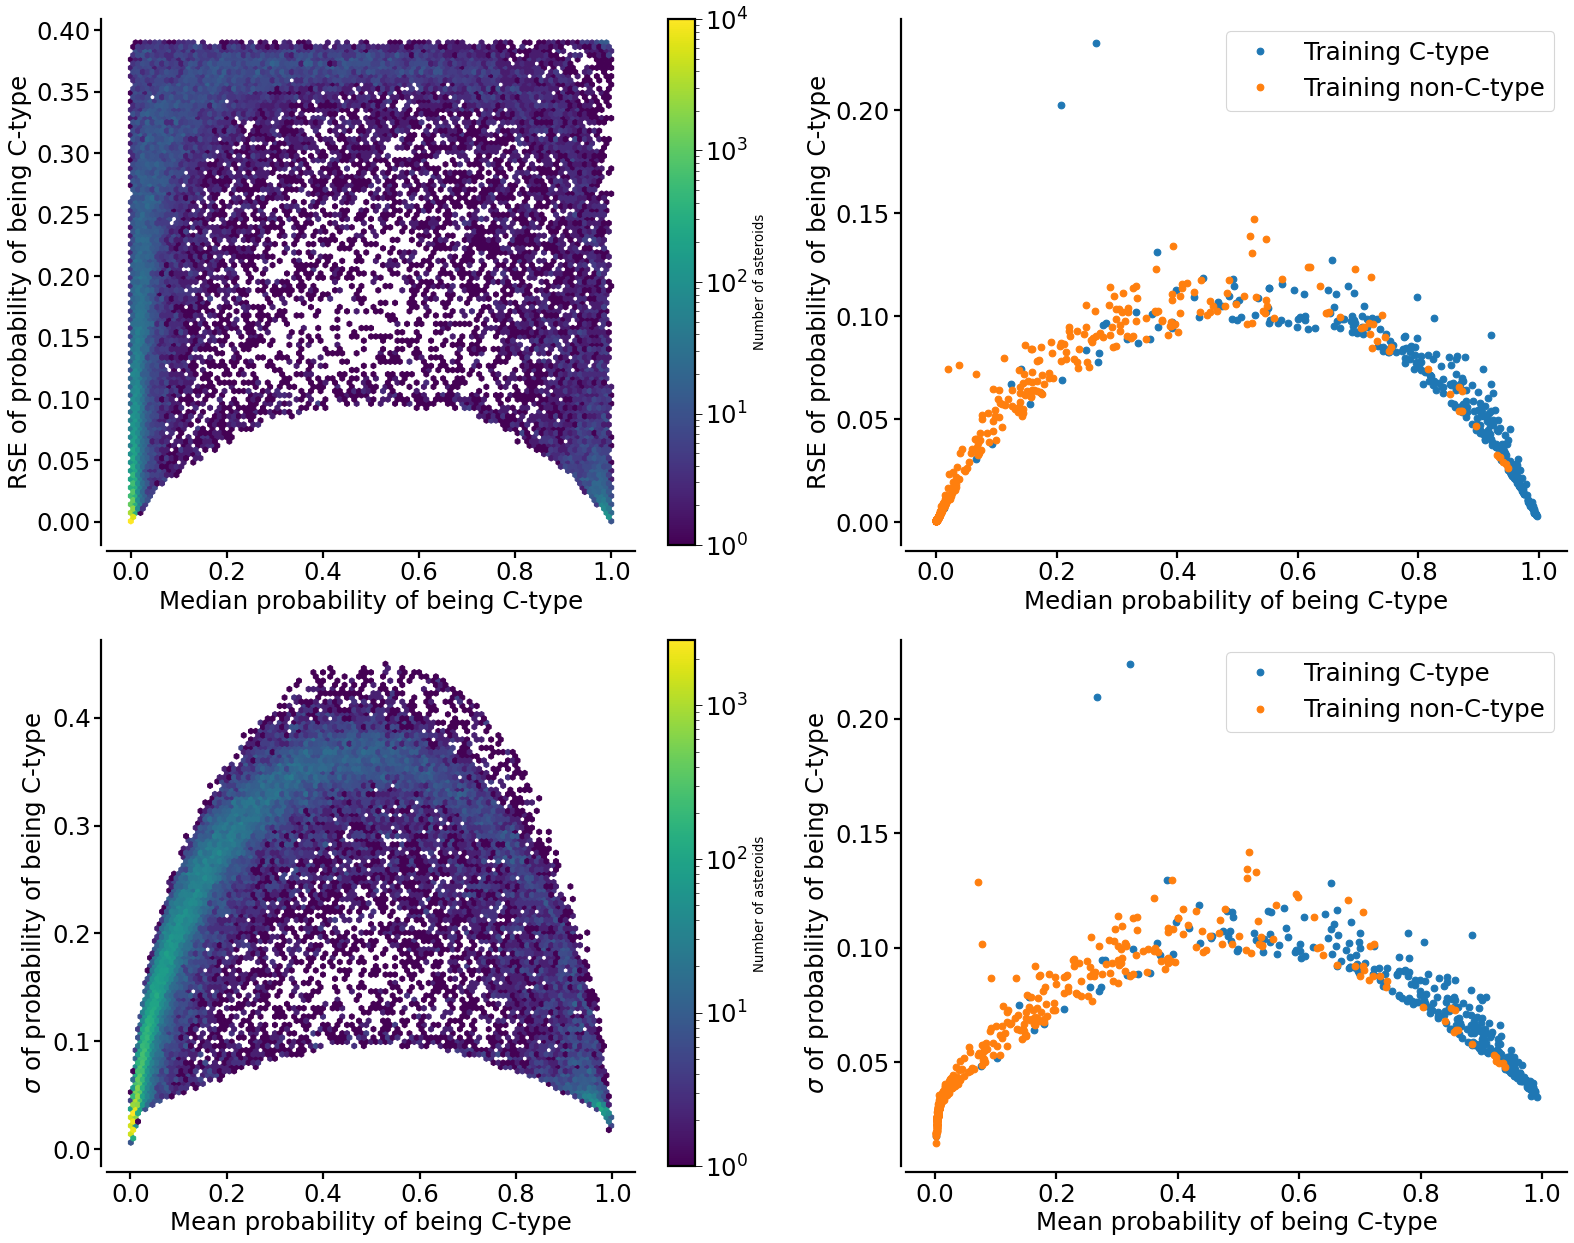

In [28]:
fig = plt.figure(figsize=(2 * 10, 2 * 8), tight_layout=True)
gs = GridSpec(2, 2, figure=fig)
axprobs = []
axprobs.append(fig.add_subplot(gs[0, 0]))
axprobs.append(fig.add_subplot(gs[0, 1]))
axprobs.append(fig.add_subplot(gs[1, 0]))
axprobs.append(fig.add_subplot(gs[1, 1]))
for axx in axprobs:
    apply_tufte(axx)

p_ctypes = ssoparams.ctype_median_prob[np.isin(ssoparams.number_mp, ssotypes["C"])]
rse_ctypes = ssoparams.ctype_rse_prob[np.isin(ssoparams.number_mp, ssotypes["C"])]
p_non_ctypes = ssoparams.ctype_median_prob[
    np.isin(ssoparams.number_mp, ssotypes["other"])
]
rse_non_ctypes = ssoparams.ctype_rse_prob[
    np.isin(ssoparams.number_mp, ssotypes["other"])
]

im = axprobs[0].hexbin(
    ssoparams.ctype_median_prob, ssoparams.ctype_rse_prob, mincnt=1, bins="log"
)
axprobs[0].set_xlabel("Median probability of being C-type")
axprobs[0].set_ylabel("RSE of probability of being C-type")
cbar = fig.colorbar(im, ax=axprobs[0])
cbar.set_label("Number of asteroids", fontsize=12)

axprobs[1].plot(p_ctypes, rse_ctypes, "o", label="Training C-type")
axprobs[1].plot(p_non_ctypes, rse_non_ctypes, "o", label="Training non-C-type")
axprobs[1].set_xlabel("Median probability of being C-type")
axprobs[1].set_ylabel("RSE of probability of being C-type")
axprobs[1].legend()

# Now mean and standard deviation

pm_ctypes = ssoparams.ctype_mean_prob[np.isin(ssoparams.number_mp, ssotypes["C"])]
std_ctypes = ssoparams.ctype_std_prob[np.isin(ssoparams.number_mp, ssotypes["C"])]
pm_non_ctypes = ssoparams.ctype_mean_prob[
    np.isin(ssoparams.number_mp, ssotypes["other"])
]
std_non_ctypes = ssoparams.ctype_std_prob[
    np.isin(ssoparams.number_mp, ssotypes["other"])
]

im = axprobs[2].hexbin(
    ssoparams.ctype_mean_prob, ssoparams.ctype_std_prob, mincnt=1, bins="log"
)
axprobs[2].set_xlabel("Mean probability of being C-type")
axprobs[2].set_ylabel(r"$\sigma$ of probability of being C-type")
cbar = fig.colorbar(im, ax=axprobs[2])
cbar.set_label("Number of asteroids", fontsize=12)

axprobs[3].plot(pm_ctypes, std_ctypes, "o", label="Training C-type")
axprobs[3].plot(pm_non_ctypes, std_non_ctypes, "o", label="Training non-C-type")
axprobs[3].set_xlabel("Mean probability of being C-type")
axprobs[3].set_ylabel(r"$\sigma$ of probability of being C-type")
axprobs[3].legend()

plt.show()

### Class definitions
The plots above show that there is no very clear separation between C-types and other types for the training data, although the true positives dominate for $\theta\gtrsim0.8$.

One can thus opt for the following class definitions:
* C-type $\theta\geq0.8$ and $\zeta\leq0.1$
* Non C-type $\theta\leq0.2$ and $\zeta\leq0.1$

The limit on $\zeta$ is to ensure that an asteroid is robustly classified as C-type.

Now we look at example spectra of asteroids confidently classified as C-type or "other" according to the above criteria.

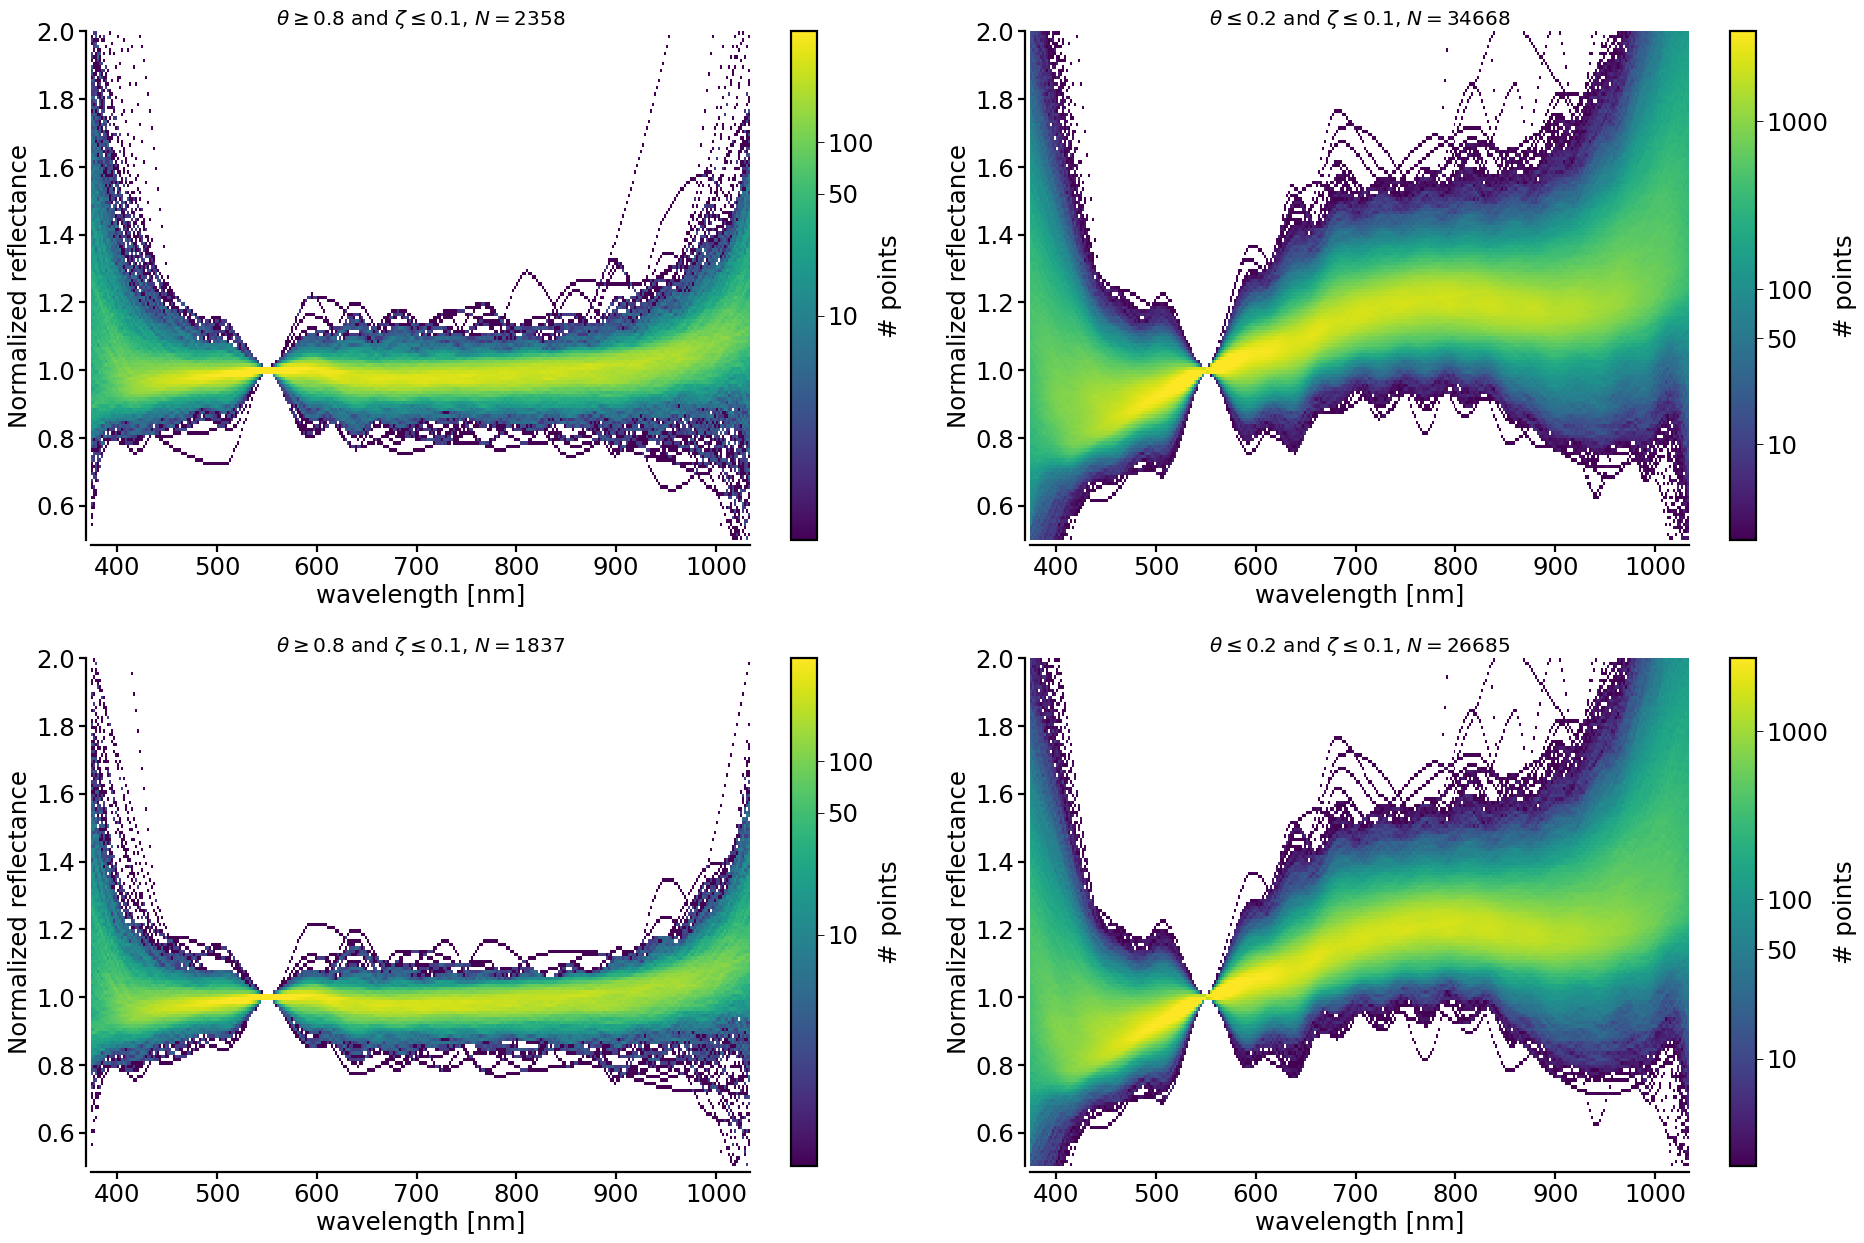

In [25]:
fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)
gs = GridSpec(2, 2, figure=fig)
axspectra = []
axspectra.append(fig.add_subplot(gs[0, 0]))
axspectra.append(fig.add_subplot(gs[0, 1]))
axspectra.append(fig.add_subplot(gs[1, 0]))
axspectra.append(fig.add_subplot(gs[1, 1]))
for axx in axspectra:
    apply_tufte(axx)

rsemax = 0.1
stdmax = 0.1
pctype = 0.8
pnon = 0.2

ctypes_nums = ssoparams.number_mp[
    (ssoparams.ctype_median_prob >= pctype) & (ssoparams.ctype_rse_prob <= rsemax)
].to_list()
nonctypes_nums = ssoparams.number_mp[
    (ssoparams.ctype_median_prob <= pnon) & (ssoparams.ctype_rse_prob <= rsemax)
].to_list()

plot_spectra_collection(
    ssospectra, axspectra[0], fig, ctypes_nums, cbarticks=[10, 50, 100]
)
axspectra[0].set_title(
    rf"$\theta\geq{pctype}$ and $\zeta\leq{rsemax}$, $N={len(ctypes_nums)}$",
    fontsize=18,
)
axspectra[0].set_xlabel("wavelength [nm]")
axspectra[0].set_ylabel("Normalized reflectance")

plot_spectra_collection(
    ssospectra, axspectra[1], fig, nonctypes_nums, cbarticks=[10, 50, 100, 1000]
)
axspectra[1].set_title(
    rf"$\theta\leq{pnon}$ and $\zeta\leq{rsemax}$, $N={len(nonctypes_nums)}$",
    fontsize=18,
)
axspectra[1].set_xlabel("wavelength [nm]")
axspectra[1].set_ylabel("Normalized reflectance")

# Now mean and standard deviation seperation

ctypes_nums = ssoparams.number_mp[
    (ssoparams.ctype_mean_prob >= pctype) & (ssoparams.ctype_std_prob <= stdmax)
].to_list()
nonctypes_nums = ssoparams.number_mp[
    (ssoparams.ctype_mean_prob <= pnon) & (ssoparams.ctype_std_prob <= stdmax)
].to_list()

plot_spectra_collection(
    ssospectra, axspectra[2], fig, ctypes_nums, cbarticks=[10, 50, 100]
)
axspectra[2].set_title(
    rf"$\theta\geq{pctype}$ and $\zeta\leq{rsemax}$, $N={len(ctypes_nums)}$",
    fontsize=18,
)
axspectra[2].set_xlabel("wavelength [nm]")
axspectra[2].set_ylabel("Normalized reflectance")

plot_spectra_collection(
    ssospectra, axspectra[3], fig, nonctypes_nums, cbarticks=[10, 50, 100, 1000]
)
axspectra[3].set_title(
    rf"$\theta\leq{pnon}$ and $\zeta\leq{rsemax}$, $N={len(nonctypes_nums)}$",
    fontsize=18,
)
axspectra[3].set_xlabel("wavelength [nm]")
axspectra[3].set_ylabel("Normalized reflectance")

plt.show()

## Among the C-types identify those with and without a hydration band

The same classification algorithm and method is used as above but now with a training set that contains only C-type asteroids with and without the h-band.

__NOTE__ The spectra are now used in their reduced form, thus discarding the first and last three wavelength bins.

Only the asteroids identified as C-type according to the chosen $\theta$ and $\zeta$ thresholds above are now classified.

In [29]:
htraining_spectra, htraining_labels, hdata_to_be_classified = prep_classifier_inputs(
    ssospectra,
    ssotypes,
    classlabels=("C_h", "C_no_h"),
    wrange=(3, 13),
    ssolist=ctypes_nums,
)

In [30]:
# Run the algorithm m times, each time with a different random state.
mnoise = 10
mclf = 100
hprobability_matrix = np.zeros((mnoise * mclf, len(ctypes_nums)))

# train and classify with an ensemble of neural networks
for j in tqdm(range(mnoise)):
    if j == 0:
        rrng = None
    else:
        rrng = np.random.default_rng(j)
    (
        htraining_spectra,
        htraining_labels,
        hdata_to_be_classified,
    ) = prep_classifier_inputs(
        ssospectra,
        ssotypes,
        classlabels=("C_h", "C_no_h"),
        rng=rrng,
        wrange=(3, 13),
        ssolist=ctypes_nums,
    )
    for jj in range(mclf):
        clf = MLPClassifier(
            solver="lbfgs",
            hidden_layer_sizes=(200, 200, 200, 200),
            max_iter=500,
            random_state=jj,
        )
        clf.fit(htraining_spectra, htraining_labels)

        hband_index = np.argwhere(clf.classes_ == 1).ravel()[0]
        hprobability_matrix[j * mclf + jj, :] = clf.predict_proba(
            hdata_to_be_classified
        )[:, hband_index]

  0%|          | 0/10 [00:00<?, ?it/s]/home/brown/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/brown/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/brown/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarnin

### Examine the results
First the median probabilities and their RSEs are stored in the `hssoparams` DataFrame. This table is then used to plot various aspects of the results.

In [31]:
hssoparams = ssoparams.loc[np.isin(ssoparams.number_mp, ctypes_nums)].copy()
hssoparams["hband_median_prob"] = np.median(hprobability_matrix, axis=0)
hssoparams["hband_rse_prob"] = rse(hprobability_matrix, ax=0)
hssoparams["hband_mean_prob"] = np.mean(hprobability_matrix, axis=0)
hssoparams["hband_std_prob"] = np.std(hprobability_matrix, axis=0)
Table.from_pandas(hssoparams).write(
    "./outputs/DR3ReflSpectraHvsNoHband.fits", format="fits", overwrite=True
)

### Histogram of class probabilities
Histograms of $\theta$ are shown below for different thresholds on $\zeta$. A clear seperation between $\theta\sim0$ and $\theta\sim1$ starts to appear for $\zeta\lesssim0.1$.

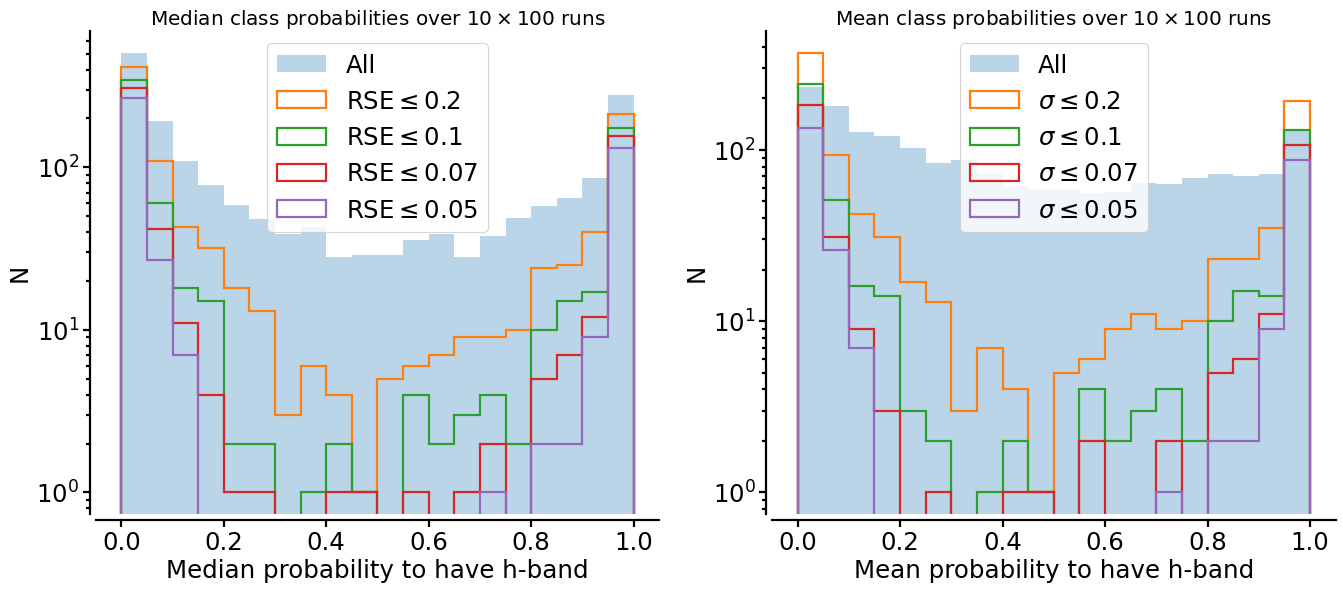

In [34]:
fig, (axD, axE) = plt.subplots(1, 2, figsize=(2 * 10, 8))
apply_tufte(axD)
apply_tufte(axE)

nbins = 20
rselims = [0.2, 0.1, 0.07, 0.05]
stdlims = rselims

axD.hist(
    hssoparams.hband_median_prob,
    bins=nbins,
    log=True,
    range=(0, 1),
    alpha=0.3,
    label="All",
)
for rselim in rselims:
    axD.hist(
        hssoparams.hband_median_prob[hssoparams.hband_rse_prob <= rselim],
        bins=nbins,
        log=True,
        range=(0, 1),
        histtype="step",
        lw=2,
        label=rf"$\mathrm{{RSE}}\leq{rselim}$",
    )
axD.set_xlabel("Median probability to have h-band")
axD.set_ylabel("N")
axD.set_title(
    rf"Median class probabilities over ${mnoise}\times{mclf}$ runs", fontsize=18
)
axD.legend()

axE.hist(
    hssoparams.hband_mean_prob,
    bins=nbins,
    log=True,
    range=(0, 1),
    alpha=0.3,
    label="All",
)
for stdlim in stdlims:
    axE.hist(
        hssoparams.hband_median_prob[hssoparams.hband_std_prob <= stdlim],
        bins=nbins,
        log=True,
        range=(0, 1),
        histtype="step",
        lw=2,
        label=rf"$\sigma\leq{stdlim}$",
    )
axE.set_xlabel("Mean probability to have h-band")
axE.set_ylabel("N")
axE.set_title(
    rf"Mean class probabilities over ${mnoise}\times{mclf}$ runs", fontsize=18
)
axE.legend()

plt.show()

Next we look at the plots of $\zeta$ vs. $\theta$ for both the full set of C-type classified asteroids and the h-band/ no h-band training sample (with known classes).

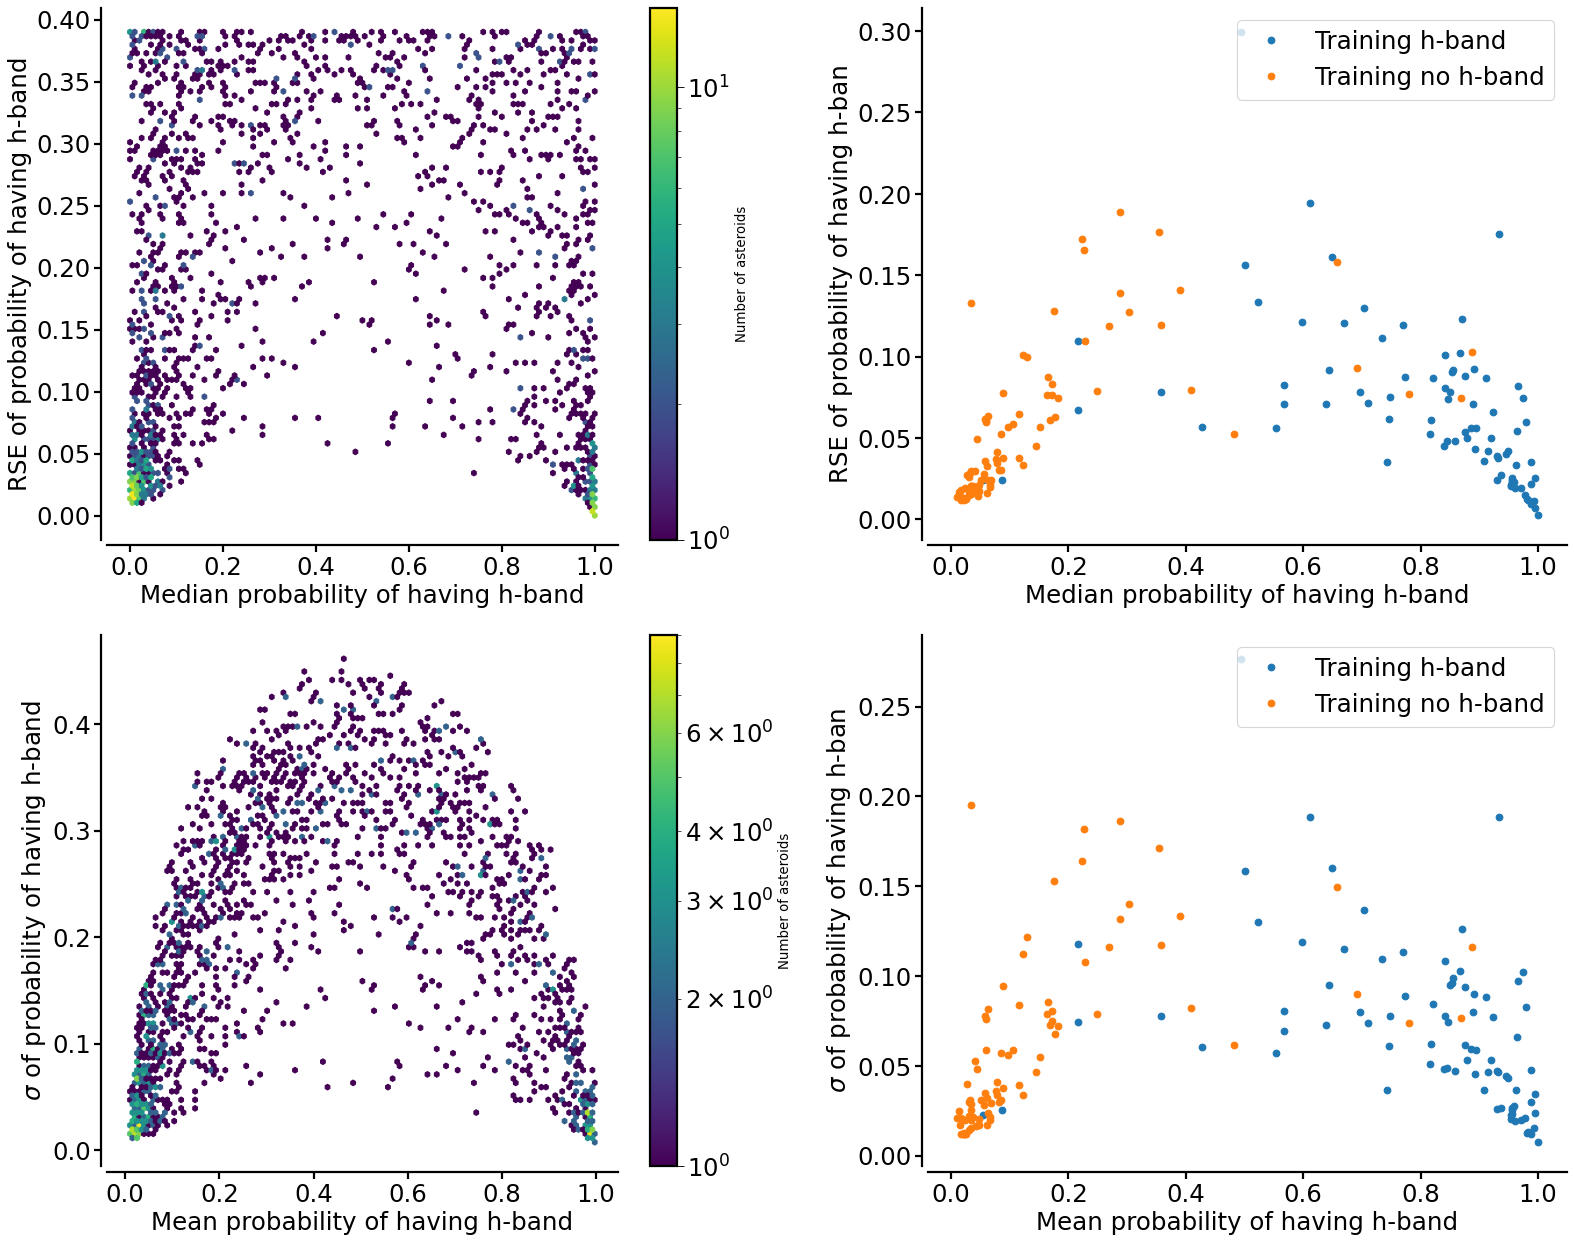

In [35]:
fig = plt.figure(figsize=(2 * 10, 2 * 8), tight_layout=True)
gs = GridSpec(2, 2, figure=fig)
axprobsh = []
axprobsh.append(fig.add_subplot(gs[0, 0]))
axprobsh.append(fig.add_subplot(gs[0, 1]))
axprobsh.append(fig.add_subplot(gs[1, 0]))
axprobsh.append(fig.add_subplot(gs[1, 1]))
for axx in axprobsh:
    apply_tufte(axx)

p_hband = hssoparams.hband_median_prob[np.isin(hssoparams.number_mp, ssotypes["C_h"])]
rse_hband = hssoparams.hband_rse_prob[np.isin(hssoparams.number_mp, ssotypes["C_h"])]
std_hband = hssoparams.hband_std_prob[np.isin(hssoparams.number_mp, ssotypes["C_h"])]

p_no_hband = hssoparams.hband_median_prob[
    np.isin(hssoparams.number_mp, ssotypes["C_no_h"])
]
rse_no_hband = hssoparams.hband_rse_prob[
    np.isin(hssoparams.number_mp, ssotypes["C_no_h"])
]
std_no_hband = hssoparams.hband_std_prob[
    np.isin(hssoparams.number_mp, ssotypes["C_no_h"])
]

im = axprobsh[0].hexbin(
    hssoparams.hband_median_prob, hssoparams.hband_rse_prob, mincnt=1, bins="log"
)
axprobsh[0].set_xlabel("Median probability of having h-band")
axprobsh[0].set_ylabel("RSE of probability of having h-band")
cbarh = fig.colorbar(im, ax=axprobsh[0])
cbarh.set_label("Number of asteroids", fontsize=12)

axprobsh[1].plot(p_hband, rse_hband, "o", label="Training h-band")
axprobsh[1].plot(p_no_hband, rse_no_hband, "o", label="Training no h-band")
axprobsh[1].set_xlabel("Median probability of having h-band")
axprobsh[1].set_ylabel("RSE of probability of having h-ban")
axprobsh[1].legend()

im = axprobsh[2].hexbin(
    hssoparams.hband_mean_prob, hssoparams.hband_std_prob, mincnt=1, bins="log"
)
axprobsh[2].set_xlabel("Mean probability of having h-band")
axprobsh[2].set_ylabel(r"$\sigma$ of probability of having h-band")
cbarh = fig.colorbar(im, ax=axprobsh[2])
cbarh.set_label("Number of asteroids", fontsize=12)

axprobsh[3].plot(p_hband, std_hband, "o", label="Training h-band")
axprobsh[3].plot(p_no_hband, std_no_hband, "o", label="Training no h-band")
axprobsh[3].set_xlabel("Mean probability of having h-band")
axprobsh[3].set_ylabel(r"$\sigma$ of probability of having h-ban")
axprobsh[3].legend()

plt.show()

### Class definitions for hydration band
Based on the plots above one can opt for the following class definitions:
* C-type with h-band: $\theta\geq0.8$ and $\zeta\leq0.1$
* C-type without h-band: $\theta\leq0.2$ and $\zeta\leq0.1$

Now we look at example spectra of asteroids confidently classified as C-type with h-band or C-type without h-band according to the above criteria.

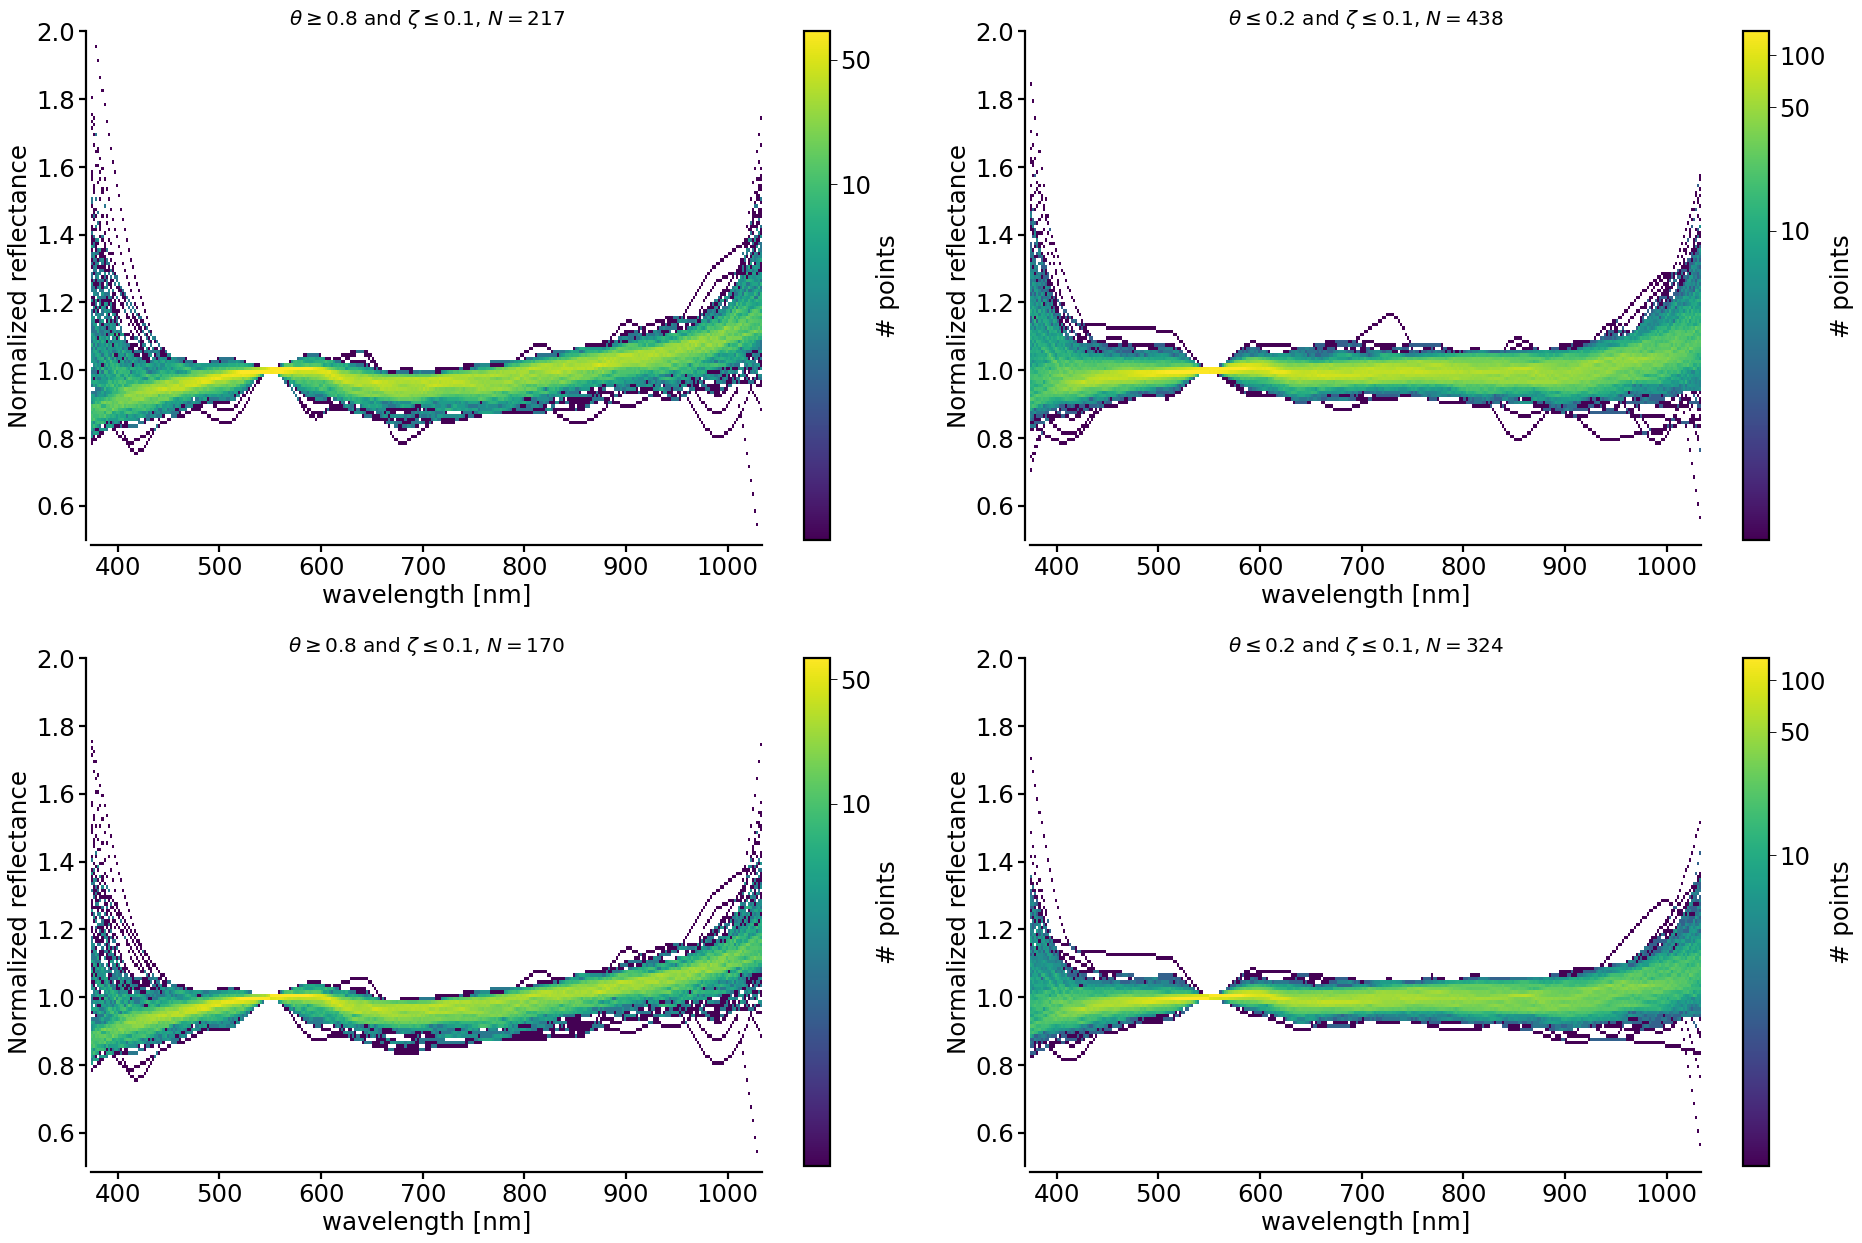

In [38]:
fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)
gs = GridSpec(2, 2, figure=fig)
axhspectra = []
axhspectra.append(fig.add_subplot(gs[0, 0]))
axhspectra.append(fig.add_subplot(gs[0, 1]))
axhspectra.append(fig.add_subplot(gs[1, 0]))
axhspectra.append(fig.add_subplot(gs[1, 1]))
for axx in axhspectra:
    apply_tufte(axx)

rsemax = 0.1
stdmax = 0.1
phband = 0.8
pnohband = 0.2

hband_nums = hssoparams.number_mp[
    (hssoparams.hband_median_prob >= phband) & (hssoparams.hband_rse_prob <= rsemax)
].to_list()
nohband_nums = hssoparams.number_mp[
    (hssoparams.hband_median_prob <= pnohband) & (hssoparams.hband_rse_prob <= rsemax)
].to_list()

plot_spectra_collection(
    ssospectra, axhspectra[0], fig, hband_nums, cbarticks=[10, 50, 100]
)
axhspectra[0].set_title(
    rf"$\theta\geq{phband}$ and $\zeta\leq{rsemax}$, $N={len(hband_nums)}$", fontsize=18
)

plot_spectra_collection(
    ssospectra, axhspectra[1], fig, nohband_nums, cbarticks=[10, 50, 100, 1000]
)
axhspectra[1].set_title(
    rf"$\theta\leq{pnon}$ and $\zeta\leq{rsemax}$, $N={len(nohband_nums)}$", fontsize=18
)

# Now separate with mean and standard deviation

hband_nums = hssoparams.number_mp[
    (hssoparams.hband_mean_prob >= phband) & (hssoparams.hband_std_prob <= stdmax)
].to_list()
nohband_nums = hssoparams.number_mp[
    (hssoparams.hband_mean_prob <= pnohband) & (hssoparams.hband_std_prob <= stdmax)
].to_list()

plot_spectra_collection(
    ssospectra, axhspectra[2], fig, hband_nums, cbarticks=[10, 50, 100]
)
axhspectra[2].set_title(
    rf"$\theta\geq{phband}$ and $\zeta\leq{rsemax}$, $N={len(hband_nums)}$", fontsize=18
)

plot_spectra_collection(
    ssospectra, axhspectra[3], fig, nohband_nums, cbarticks=[10, 50, 100, 1000]
)
axhspectra[3].set_title(
    rf"$\theta\leq{pnon}$ and $\zeta\leq{rsemax}$, $N={len(nohband_nums)}$", fontsize=18
)

plt.show()